In [1]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from collections import defaultdict
import numpy as np
import pandas as pd
import nltk, re, pprint, string
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [2]:
from models_util import build_info_lists, plot_confusion_matrix

## Prof Frank's suggestions

* the effectiveness of lexical features (e.g., unigrams or n-grams)
* grammatical features (e.g., POS unigrams or n-grams -- you could use an existing POS tagger to get data for that)
* other text properties (sentence length, punctuation usage, average word length, average word frequency, etc.)

Also, you could imagine looking both at the probabilities assigned by a pre-trained language model to your text as well as the distribution of probabilities for the words (if e.g., you use a bigram model, you could look at the properties of the distribution of bigram probabilities).

In [3]:
punct = string.punctuation +'“'+'”'+'-'+'’'+'‘'+'—'+'–'

## Reading in data & constructing dataframe

In [4]:
categs = []             # 'translation' or 'english'
texts = []              # actual text content
avg_sent_len = []       # average sentence length
avg_word_len = []       # average word length
stops = []              # percentage of stopwords
f = []
entities = []

trainDF = pd.DataFrame()

In [5]:
# translated texts
build_info_lists(categs, texts, avg_sent_len, avg_word_len, stops, "translation", f, 100) #, entities)

# english texts
build_info_lists(categs, texts, avg_sent_len, avg_word_len, stops, "english", f, 83) #, entities)

In [6]:
# store in dataframe
trainDF['file'] = f
trainDF['text'] = texts
trainDF['categ'] = categs
trainDF['avg_sent'] = avg_sent_len
trainDF['avg_word'] = avg_word_len
trainDF['stopwords'] = stops
# trainDF['entities'] = entities

In [7]:
# TRANSFORM THE CATEGORICAL VARIABLE INTO A NUMERIC LABEL
# cat = pd.get_dummies(trainDF.categ)
# trainDF = pd.concat([trainDF, cat], axis=1)
trainDF['label'] = trainDF['categ'].apply(lambda x: 0 if x == "english" else 1)

In [8]:
trainDF

,file,text,categ,avg_sent,avg_word,stopwords,label
0,translation_1,I keep a keen eye on the development of Russia...,translation,17.544118,4.403185,0.564124,1
1,translation_2,A serious scandal has erupted around John Kerr...,translation,21.293333,4.984346,0.482780,1
2,translation_3,Arms trafficking from the U.S. to Mexico has g...,translation,24.625000,4.840102,0.472081,1
3,translation_4,Joe Biden has just officially recognized the A...,translation,33.611111,5.084298,0.480992,1
4,translation_5,Prime Minister Yoshihide Suga will meet U.S. P...,translation,18.240000,4.964912,0.423246,1
...,...,...,...,...,...,...,...
178,english_79,US President Joe Biden is not moving quickly t...,english,17.454545,4.880208,0.466146,0
179,english_80,A senior US delegation is visiting the Middle ...,english,22.000000,5.038462,0.411422,0
180,english_81,US Secretary of State Antony Blinken delivered...,english,20.945946,4.971613,0.470968,0
181,english_82,U.S. President Joe Biden recognized the 1915 e...,english,20.446809,5.002081,0.463059,0


In [9]:
trainDF.shape

(183, 7)

In [10]:
# Random t-test to see if there is a statistically significant difference between
# the percentage of stop words in translated vs english texts

from scipy.stats import ttest_ind

print(trainDF[trainDF['categ'] == "translation"]['stopwords'].mean())
print(trainDF[trainDF['categ'] == "english"]['stopwords'].mean())

cat1 = trainDF[trainDF['categ'] == 'translation']
cat2 = trainDF[trainDF['categ'] == 'english']

ttest_ind(cat1['stopwords'], cat2['stopwords'])

0.45389072913791717
0.4361334759794676


Ttest_indResult(statistic=3.500912474799324, pvalue=0.0005838698156661424)

In [11]:
# make the relevant columns of the dataframe into a feature matrix
feat_v = trainDF.drop(['categ', 'label'], axis=1).to_numpy()
trainDF.drop(['categ', 'label'], axis=1)

,file,text,avg_sent,avg_word,stopwords
0,translation_1,I keep a keen eye on the development of Russia...,17.544118,4.403185,0.564124
1,translation_2,A serious scandal has erupted around John Kerr...,21.293333,4.984346,0.482780
2,translation_3,Arms trafficking from the U.S. to Mexico has g...,24.625000,4.840102,0.472081
3,translation_4,Joe Biden has just officially recognized the A...,33.611111,5.084298,0.480992
4,translation_5,Prime Minister Yoshihide Suga will meet U.S. P...,18.240000,4.964912,0.423246
...,...,...,...,...,...
178,english_79,US President Joe Biden is not moving quickly t...,17.454545,4.880208,0.466146
179,english_80,A senior US delegation is visiting the Middle ...,22.000000,5.038462,0.411422
180,english_81,US Secretary of State Antony Blinken delivered...,20.945946,4.971613,0.470968
181,english_82,U.S. President Joe Biden recognized the 1915 e...,20.446809,5.002081,0.463059


In [12]:
# create a count matrix (bag-of-words / ngram features)

# u'((?ui)\\b\\w*[a-z|\'|\’]+\\w*\\b)'
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 1))
cv = count_vect.fit(trainDF['text'])

xtrain_count = count_vect.transform(trainDF['text'])

word_v = xtrain_count.toarray()

len(cv.vocabulary_)

12054

In [13]:
# concatenate these ngram features with the other features we made in the dataframe
full_v = np.concatenate((feat_v, word_v), axis=1)

In [14]:
# split the examples into train & test (validation) sets
# X_train, X_test, y_train, y_test = model_selection.train_test_split(full_v, trainDF['label'], random_state=1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(full_v, trainDF['label'], random_state=1)

In [15]:
feat_v.shape

(183, 5)

## Multinomial Naive Bayes

In [16]:
# multinomial naive bayes - model is good with unigrams
nb = naive_bayes.MultinomialNB()
nb.fit(X_train[:, 2:], y_train)
predictions = nb.predict(X_test[:, 2:])

print('Accuracy score: ', metrics.accuracy_score(y_test, predictions))
print('Precision score: ', metrics.precision_score(y_test, predictions))
print('Recall score: ', metrics.recall_score(y_test, predictions))

Accuracy score:  0.8695652173913043
Precision score:  0.8064516129032258
Recall score:  1.0


In [17]:
# print confusion matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

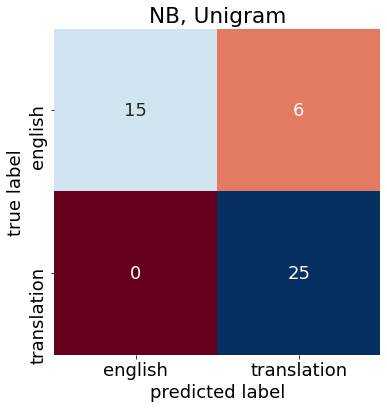

In [18]:
plot_confusion_matrix(y_test, predictions, "NB, Unigram", "nb_unigrams.png")

In [19]:
testing_predictions = []
for i in range(len(X_test)):
    if predictions[i] == 1:
        testing_predictions.append('translation')
    else:
        testing_predictions.append('english')
check_df = pd.DataFrame({'actual_label': list(y_test), 'prediction': testing_predictions, 'text':list(X_test[:, 1]), 'file':list(X_test[:, 0])})
check_df.replace(to_replace=0, value='english', inplace=True)
check_df.replace(to_replace=1, value='translation', inplace=True)

In [20]:
check_df.head()

,actual_label,prediction,text,file
0,translation,translation,"On April 14, a delegation of retired US offici...",translation_54
1,translation,translation,Joe Biden is preparing to become the 46th pres...,translation_92
2,english,translation,China specialists in the United States are beg...,english_19
3,english,translation,US President Joe Biden is not moving quickly t...,english_79
4,translation,translation,Global corporations played a decisive role in ...,translation_48


In [21]:
# df

In [22]:
categs = []             # 'translation' or 'english'
texts = []              # actual text content
avg_sent_len = []       # average sentence length
avg_word_len = []       # average word length
stops = []              # percentage of stopwords
f = []
entities = []

df = pd.DataFrame()
build_info_lists(categs, texts, avg_sent_len, avg_word_len, stops, "test", f, 1) #, entities)

df['file'] = f
df['text'] = texts
df['categ'] = categs
df['avg_sent'] = avg_sent_len
df['avg_word'] = avg_word_len
df['stopwords'] = stops
# df['entities'] = entities
feat_test_v = df.drop(['categ'], axis=1).to_numpy()

xtrain_count = count_vect.transform(df['text'])
word_test_v = xtrain_count.toarray()

test_v = np.concatenate((feat_test_v, word_test_v), axis=1)
test_y = [0]

predictions = nb.predict(test_v[:, 2:])

testing_predictions = []
for i in range(len(test_v)):
    if predictions[i] == 1:
        testing_predictions.append('translation')
    else:
        testing_predictions.append('english')
check_df = pd.DataFrame({'actual_label': list(test_y), 'prediction': testing_predictions, 'text':list(test_v[:, 1]), 'file':list(test_v[:, 0])})
check_df.replace(to_replace=0, value='english', inplace=True)
check_df.replace(to_replace=1, value='translation', inplace=True)

In [23]:
check_df

,actual_label,prediction,text,file
0,english,english,Russian President Vladimir Putin is provoking ...,test_1


In [24]:
# create a count matrix (bag-of-words / ngram features)
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 1))
cv = count_vect.fit(trainDF['text'])
xtrain_count = count_vect.transform(trainDF['text'])
word_v = xtrain_count.toarray()

# tf-idf vectors as features
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000, ngram_range=(2, 3))
tv = tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(trainDF['text'])
word_tv = xtrain_tfidf.toarray()

# concatenate these ngram features with the other features we made in the dataframe
full_v = np.concatenate((feat_v, word_v, word_tv), axis=1)
count_ind = feat_v.shape[1]
tfidf_ind = count_ind + word_v.shape[1]

# split the examples into train & test (validation) sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(full_v, trainDF['label'], random_state=1)

In [25]:
nb = naive_bayes.MultinomialNB()
nb.fit(X_train[:, 2:tfidf_ind], y_train)
predictions = nb.predict(X_test[:, 2:tfidf_ind])
print('Accuracy score: ', metrics.accuracy_score(y_test, predictions))
print('Precision score: ', metrics.precision_score(y_test, predictions))
print('Recall score: ', metrics.recall_score(y_test, predictions))

Accuracy score:  0.8695652173913043
Precision score:  0.8064516129032258
Recall score:  1.0


Text(0.5, 25.0, 'predicted label')

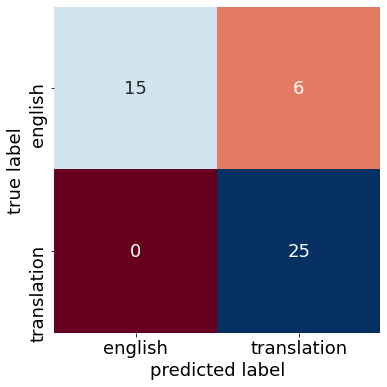

In [26]:
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 6))
matplotlib.rcParams.update({'font.size': 18})

sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['english', 'translation'], yticklabels=['english', 'translation'])
plt.ylabel('true label')
plt.xlabel('predicted label')

### TF-IDF

In [27]:
# tf-idf vectors as features (doesn't seem to work very well?)
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000, ngram_range=(2, 2))  # max_features=5000, 
tv = tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(trainDF['text'])

In [28]:
word_tv = xtrain_tfidf.toarray()
len(tv.vocabulary_)

5000

In [29]:
full_tv = np.concatenate((feat_v, word_tv), axis=1)

In [30]:
feat_v.shape

(183, 5)

In [31]:
X_traint, X_testt, y_traint, y_testt = model_selection.train_test_split(word_tv, trainDF['label'], random_state=1)

In [32]:
np.concatenate((X_train[:, 2:count_ind], X_train[:, tfidf_ind:]), axis=1).shape

(137, 5003)

In [33]:
np.concatenate((X_test[:, 2:count_ind], X_test[:, tfidf_ind:]), axis=1).shape

(46, 5003)

In [34]:
t_x_train = np.concatenate((X_train[:, 2:count_ind], X_train[:, tfidf_ind:]), axis=1)
t_x_test = np.concatenate((X_test[:, 2:count_ind], X_test[:, tfidf_ind:]), axis=1)
nb_tfidf = naive_bayes.MultinomialNB()
nb_tfidf.fit(X_train[:, tfidf_ind:], y_train)
predictions = nb_tfidf.predict(X_test[:, tfidf_ind:])
print('Accuracy score: ', metrics.accuracy_score(y_test, predictions))
print('Precision score: ', metrics.precision_score(y_test, predictions))
print('Recall score: ', metrics.recall_score(y_test, predictions))

Accuracy score:  0.782608695652174
Precision score:  0.7142857142857143
Recall score:  1.0


Text(0.5, 7.0, 'predicted label')

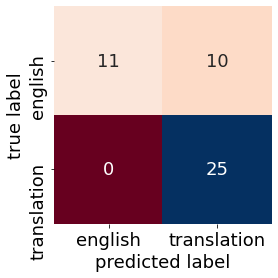

In [35]:
cm = metrics.confusion_matrix(y_test, predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['english', 'translation'], yticklabels=['english', 'translation'])
plt.ylabel('true label')
plt.xlabel('predicted label')

In [36]:
predictions

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0], dtype=int64)

## Logistic Regression

Accuracy score:  0.782608695652174
Precision score:  0.8260869565217391
Recall score:  0.76


C:\Users\pearl\Documents\clay-gpt\env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 7.0, 'predicted label')

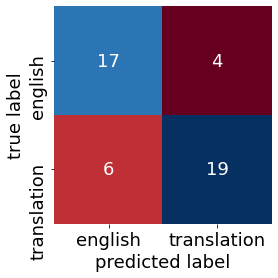

In [37]:
lm = linear_model.LogisticRegression()
lm.fit(X_train[:, 2:], y_train)
predictions = lm.predict(X_test[:, 2:])
print('Accuracy score: ', metrics.accuracy_score(y_test, predictions))
print('Precision score: ', metrics.precision_score(y_test, predictions))
print('Recall score: ', metrics.recall_score(y_test, predictions))
cm = metrics.confusion_matrix(y_test, predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['english', 'translation'], yticklabels=['english', 'translation'])
plt.ylabel('true label')
plt.xlabel('predicted label')

## SVM
https://monkeylearn.com/blog/introduction-to-support-vector-machines-svm/

Accuracy score:  0.8043478260869565
Precision score:  0.8076923076923077
Recall score:  0.84


Text(0.5, 7.0, 'predicted label')

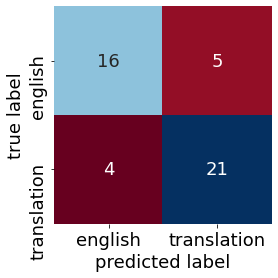

In [38]:
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train[:, 2:], y_train)
predictions = SVM.predict(X_test[:, 2:])
# Use accuracy_score function to get the accuracy
print('Accuracy score: ', metrics.accuracy_score(y_test, predictions))
print('Precision score: ', metrics.precision_score(y_test, predictions))
print('Recall score: ', metrics.recall_score(y_test, predictions))
cm = metrics.confusion_matrix(y_test, predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['english', 'translation'], yticklabels=['english', 'translation'])
plt.ylabel('true label')
plt.xlabel('predicted label')

## Neural Networks

### Shallow

In [39]:
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    if is_neural_net:
#         feature_vector_train = np.asarray(feature_vector_train).astype(np.float32)
        classifier.fit(np.asarray(feature_vector_train).astype(np.float32), label, epochs=150)
    else:
        classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(np.asarray(feature_vector_valid).astype(np.float32))
    
    if is_neural_net:
        predictions = predictions > 0.5
        
    return predictions

In [40]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(180, activation="relu")(input_layer)
        
    # create output layer
    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return classifier

In [41]:
classifier = create_model_architecture(X_train[:, tfidf_ind:].shape[1])
predictions = train_model(classifier, X_train[:, tfidf_ind:], y_train, X_test[:, tfidf_ind:], is_neural_net=True)
print('Accuracy score: ', metrics.accuracy_score(y_test, predictions))
print('Precision score: ', metrics.precision_score(y_test, predictions))
print('Recall score: ', metrics.recall_score(y_test, predictions))

Epoch 1/150
5/5 [==============================] - 0s 3ms/step - loss: 0.6908
Epoch 2/150
5/5 [==============================] - 0s 3ms/step - loss: 0.6239
Epoch 3/150
5/5 [==============================] - 0s 3ms/step - loss: 0.5493
Epoch 4/150
5/5 [==============================] - 0s 3ms/step - loss: 0.4745
Epoch 5/150
5/5 [==============================] - 0s 3ms/step - loss: 0.3801
Epoch 6/150
5/5 [==============================] - 0s 3ms/step - loss: 0.3128
Epoch 7/150
5/5 [==============================] - 0s 3ms/step - loss: 0.2464
Epoch 8/150
5/5 [==============================] - 0s 3ms/step - loss: 0.1902
Epoch 9/150
5/5 [==============================] - 0s 3ms/step - loss: 0.1471
Epoch 10/150
5/5 [==============================] - 0s 3ms/step - loss: 0.1170
Epoch 11/150
5/5 [==============================] - 0s 3ms/step - loss: 0.0874
Epoch 12/150
5/5 [==============================] - 0s 3ms/step - loss: 0.0693
Epoch 13/150
5/5 [==============================] - 0s 3ms/st

5/5 [==============================] - 0s 3ms/step - loss: 6.9456e-04
Epoch 104/150
5/5 [==============================] - 0s 3ms/step - loss: 7.0058e-04
Epoch 105/150
5/5 [==============================] - 0s 3ms/step - loss: 6.4824e-04
Epoch 106/150
5/5 [==============================] - 0s 3ms/step - loss: 6.3888e-04
Epoch 107/150
5/5 [==============================] - 0s 3ms/step - loss: 5.9973e-04
Epoch 108/150
5/5 [==============================] - 0s 3ms/step - loss: 6.2068e-04
Epoch 109/150
5/5 [==============================] - 0s 3ms/step - loss: 6.2006e-04
Epoch 110/150
5/5 [==============================] - 0s 3ms/step - loss: 5.7778e-04
Epoch 111/150
5/5 [==============================] - 0s 3ms/step - loss: 5.8352e-04
Epoch 112/150
5/5 [==============================] - 0s 3ms/step - loss: 5.7991e-04
Epoch 113/150
5/5 [==============================] - 0s 3ms/step - loss: 5.6402e-04
Epoch 114/150
5/5 [==============================] - 0s 3ms/step - loss: 5.4986e-04
Epoch 

In [42]:
classifier.save('filename')

INFO:tensorflow:Assets written to: filename\assets


In [43]:
model = models.load_model('filename')

In [44]:
predictions = model.predict(np.asarray(X_test[:, tfidf_ind:]).astype(np.float32)) > 0.5
print('Accuracy score: ', metrics.accuracy_score(y_test, predictions))
print('Precision score: ', metrics.precision_score(y_test, predictions))
print('Recall score: ', metrics.recall_score(y_test, predictions))

Accuracy score:  0.9130434782608695
Precision score:  0.8888888888888888
Recall score:  0.96


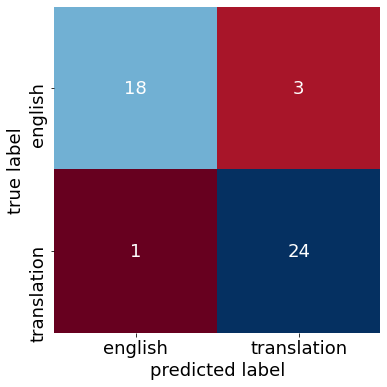

In [45]:
cm = metrics.confusion_matrix(y_testt, predictions)
plt.figure(figsize=(6, 6))
matplotlib.rcParams.update({'font.size': 18})

sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False,
xticklabels=['english', 'translation'], yticklabels=['english', 'translation'])
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.savefig("nn_tfidf_unigram.png")

In [47]:
feat_test_v = df.drop(['categ'], axis=1).to_numpy()
xtrain_count = tfidf_vect.transform(df['text'])
word_test_v = xtrain_count.toarray()

test_v = np.concatenate((feat_test_v, word_test_v), axis=1)
test_y = [0]

predictions = classifier.predict(np.asarray(word_test_v).astype(np.float32))

testing_predictions = []
for i in range(len(test_v)):
    if predictions[i] == 1:
        testing_predictions.append('translation')
    else:
        testing_predictions.append('english')
check_df = pd.DataFrame({'actual_label': list(test_y), 'prediction': testing_predictions, 'text':list(test_v[:, 1]), 'file':list(test_v[:, 0])})
check_df.replace(to_replace=0, value='english', inplace=True)
check_df.replace(to_replace=1, value='translation', inplace=True)

In [48]:
check_df

,actual_label,prediction,text,file
0,english,english,Russian President Vladimir Putin is provoking ...,test_1


### Convolutional Neural Network

In [49]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

#### GloVe embeddings

In [50]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(trainDF['text'], trainDF['label'], random_state=1)

# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open("data/glove.6B.300d.txt", 'r', encoding="utf-8")):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(trainDF['text'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=70)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [51]:
classifier = create_cnn()
predictions = train_model(classifier, train_seq_x, y_train, valid_seq_x, is_neural_net=True)
print('Accuracy score: ', metrics.accuracy_score(y_test, predictions))
print('Precision score: ', metrics.precision_score(y_test, predictions))
print('Recall score: ', metrics.recall_score(y_test, predictions))

Epoch 1/150
5/5 [==============================] - 1s 9ms/step - loss: 0.7524
Epoch 2/150
5/5 [==============================] - 0s 8ms/step - loss: 0.7536
Epoch 3/150
5/5 [==============================] - 0s 8ms/step - loss: 0.6358
Epoch 4/150
5/5 [==============================] - 0s 8ms/step - loss: 0.5811
Epoch 5/150
5/5 [==============================] - 0s 8ms/step - loss: 0.5811
Epoch 6/150
5/5 [==============================] - 0s 8ms/step - loss: 0.5218
Epoch 7/150
5/5 [==============================] - 0s 8ms/step - loss: 0.5057
Epoch 8/150
5/5 [==============================] - 0s 8ms/step - loss: 0.4693
Epoch 9/150
5/5 [==============================] - 0s 7ms/step - loss: 0.4759
Epoch 10/150
5/5 [==============================] - 0s 8ms/step - loss: 0.3973
Epoch 11/150
5/5 [==============================] - 0s 8ms/step - loss: 0.3289
Epoch 12/150
5/5 [==============================] - 0s 8ms/step - loss: 0.3505
Epoch 13/150
5/5 [==============================] - 0s 8ms/st

5/5 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 105/150
5/5 [==============================] - 0s 8ms/step - loss: 9.9215e-04
Epoch 106/150
5/5 [==============================] - 0s 9ms/step - loss: 5.8159e-04
Epoch 107/150
5/5 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 108/150
5/5 [==============================] - 0s 9ms/step - loss: 8.9067e-04
Epoch 109/150
5/5 [==============================] - 0s 8ms/step - loss: 7.2422e-04
Epoch 110/150
5/5 [==============================] - 0s 10ms/step - loss: 4.2738e-04
Epoch 111/150
5/5 [==============================] - 0s 9ms/step - loss: 0.0015
Epoch 112/150
5/5 [==============================] - 0s 10ms/step - loss: 6.7254e-04
Epoch 113/150
5/5 [==============================] - 0s 9ms/step - loss: 6.1097e-04
Epoch 114/150
5/5 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 115/150
5/5 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 116/150
5/5 [=====

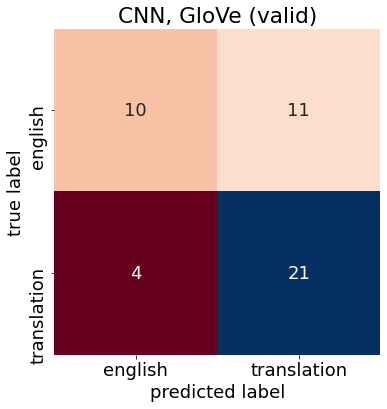

In [52]:
plot_confusion_matrix(y_test, predictions, "CNN, GloVe (valid)", "CNN, GloVe (validation set)")

### Recurrent Neural Network

In [53]:
def create_rnn_lstm():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

In [54]:
classifier = create_rnn_lstm()
predictions = train_model(classifier, train_seq_x, y_train, valid_seq_x, is_neural_net=True)
print('Accuracy score: ', metrics.accuracy_score(y_test, predictions))
print('Precision score: ', metrics.precision_score(y_test, predictions))
print('Recall score: ', metrics.recall_score(y_test, predictions))

Epoch 1/150
5/5 [==============================] - 2s 39ms/step - loss: 0.6799
Epoch 2/150
5/5 [==============================] - 0s 32ms/step - loss: 0.6685
Epoch 3/150
5/5 [==============================] - 0s 33ms/step - loss: 0.6408
Epoch 4/150
5/5 [==============================] - 0s 37ms/step - loss: 0.6135
Epoch 5/150
5/5 [==============================] - 0s 32ms/step - loss: 0.6015
Epoch 6/150
5/5 [==============================] - 0s 31ms/step - loss: 0.5591
Epoch 7/150
5/5 [==============================] - 0s 35ms/step - loss: 0.5049
Epoch 8/150
5/5 [==============================] - 0s 39ms/step - loss: 0.4755
Epoch 9/150
5/5 [==============================] - 0s 36ms/step - loss: 0.4833
Epoch 10/150
5/5 [==============================] - 0s 37ms/step - loss: 0.4134
Epoch 11/150
5/5 [==============================] - 0s 32ms/step - loss: 0.4240
Epoch 12/150
5/5 [==============================] - 0s 33ms/step - loss: 0.3667
Epoch 13/150
5/5 [==============================]

5/5 [==============================] - 0s 32ms/step - loss: 0.0048
Epoch 104/150
5/5 [==============================] - 0s 31ms/step - loss: 0.0022
Epoch 105/150
5/5 [==============================] - 0s 30ms/step - loss: 0.0073
Epoch 106/150
5/5 [==============================] - 0s 30ms/step - loss: 0.0087
Epoch 107/150
5/5 [==============================] - 0s 31ms/step - loss: 6.0294e-04
Epoch 108/150
5/5 [==============================] - 0s 30ms/step - loss: 0.0015
Epoch 109/150
5/5 [==============================] - 0s 30ms/step - loss: 8.7736e-04
Epoch 110/150
5/5 [==============================] - 0s 31ms/step - loss: 0.0032
Epoch 111/150
5/5 [==============================] - 0s 29ms/step - loss: 3.3875e-04
Epoch 112/150
5/5 [==============================] - 0s 30ms/step - loss: 3.3875e-04
Epoch 113/150
5/5 [==============================] - 0s 29ms/step - loss: 7.0907e-04
Epoch 114/150
5/5 [==============================] - 0s 28ms/step - loss: 4.4539e-04
Epoch 115/150
5/5 

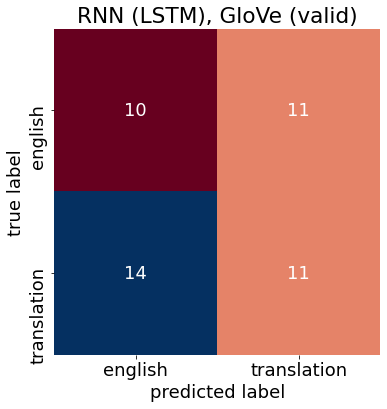

In [55]:
plot_confusion_matrix(y_test, predictions, "RNN (LSTM), GloVe (valid)", "RNN (LSTM), GloVe (validation set)")

In [56]:
from gensim.models import Word2Vec
word2vec = Word2Vec(all_words, min_count=2)


NameError: name 'all_words' is not defined

In [ ]:
f = open("translation_texts/01", encoding="utf8").read()
f = f.split('\n')
f = '\n'.join(f[2:])
sents = sent_tokenize(f)
total_wc = 0
for sent in sents:
    print(sent)
    wc = len(sent.split())
    total_wc += wc
    print(wc)

In [ ]:
print(total_wc / len(sents))